# **Import needed libraries**

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
import requests
from urllib.parse import urlparse
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer

# **Import Dataset**

In [32]:
df = pd.read_csv(filepath_or_buffer='phishing_site_urls.csv', header=0)
len(df)

549346

Data preparation
- Get Top-Level-Domain
- Get Length of Domain
- Get Amount Characters of Domain
- Get Amount of Numbers of Domain
- Get Amount of special characters of Domain
- Get IP-Address
- Get External Score
- Get Length of URL
- Get Amount of .
- Get Amount of /
- Get Amount Characters of URL
- Get Amount of Numbers of URL
- Get Amount of special characters of URL
- Get if a IP-Address is included in the URL
- Get Amount of Subdomains
- Get Length of Subdomain-Part
- Get Amount of directories
- Get Length of directory-part
- Get if URL was shortened
- Get if URL redirects
- Get Buzzwords in URL -> create Wordcloud

Unshorten URLs

new_column = []    
for values in df['URL']:
    if not re.match(r'^((http|https)://)', values):
        new_column.append("http://"+values)
    else:
        new_column.append(values)

df['http_domain'] = new_column

**Check which URLs are still working**

In [33]:
#def is_working(url):
#    try:
#        response = requests.get(url)
#        return response.status_code == 200
#    except:
#        return False

In [34]:
#df['is_working'] = df['URL'].apply(is_working)
#df.head(15)

In [35]:
#df_groupBy_isWorking = df.groupby(by=['Label', 'is_working'],as_index = False).count()
#df_groupBy_isWorking.head(10)
#print(df[df['is_working']])

Checked the working URL -> indeed these URLs are suspicious 
Unfortunatly only small amount of URLs are working -> cannot find URLs that redirect + IP-addresses + shortened URLs + no external score

**Delete all rows that contain IP-addresses from main dataframe and consider them separatly**

In [36]:
ip_regex = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b')


df_ip = df.loc[df['URL'].str.match(ip_regex)]
#df_ip = df_ip.drop('is_working', axis=1)
df_ip_groupBy_label = df_ip.groupby(by=['Label'],as_index = False).count()
amount_ip_addresses = df_ip_groupBy_label['URL'].sum()
df_ip_groupBy_label['Percentage'] = (df_ip_groupBy_label['URL'] / amount_ip_addresses) * 100

df_ip_groupBy_label.head(15)

,Label,URL,Percentage
0,bad,7823,99.668748
1,good,26,0.331252


The numbers show, that if a URL is including an IP-address it is very likely that the URL is malicious. Within the dataset 99,67% of all URLs that include an IP-address are malicious.

**General Distribution of Bad vs Good URLs**

In [37]:
df_groupBy_label = df.groupby(by=['Label'],as_index = False).count()
df_groupBy_label.head(10)
#Pie or Bar Chart

,Label,URL
0,bad,156422
1,good,392924


**Get Domain of every URL**

In [38]:
new_column = []    
for values in df['URL']:
    new_column.append(re.search(r'^((http|https)://)?[^(/|\s|:]*', values).group())

df['domain'] = new_column

**Get TLD of every URL -> if not possible to allocate delete the row**

In [39]:
new_column = []    
i = 1
for values in df['domain']:
    try:
        new_column.append(re.search(r'(?<=\.)[a-z]+(?=\/|$)', values).group())
    except:
        new_column.append("n/a")

df['tld'] = new_column

In [40]:
#Delete rows where a TLD cannot be calculated
na_rows = df.loc[df['tld'] == 'n/a']
df = df.drop(na_rows.index)

In [41]:
df_tld = df
df_tld['tld_count'] = df_tld['tld']
df_tld_groupBy_label_tld = df_tld.groupby(by=['tld', 'Label'],as_index = False).count()
amount_tld = df_tld_groupBy_label_tld['tld_count'].sum()
df_tld_pivot_label_tld = df_tld_groupBy_label_tld.pivot_table('tld_count', ['tld'], 'Label')
df_tld_pivot_label_tld['bad'] = df_tld_pivot_label_tld['bad'].fillna(0)
df_tld_pivot_label_tld['good'] = df_tld_pivot_label_tld['good'].fillna(0)
df_tld_pivot_label_tld['bad_percentage'] = (df_tld_pivot_label_tld['bad'] / (df_tld_pivot_label_tld['bad'] + df_tld_pivot_label_tld['good'])) * 100
df_tld_pivot_label_tld['overall_percentage'] = ((df_tld_pivot_label_tld['bad'] + df_tld_pivot_label_tld['good']) / amount_tld ) * 100

df_tld_pivot_label_tld = df_tld_pivot_label_tld.sort_values(by='overall_percentage', ascending=False)

df_tld_pivot_label_tld.head(20)

Label,bad,good,bad_percentage,overall_percentage
tld,,,,
com,71804.0,290219.0,19.834099,66.930984
org,5874.0,42897.0,12.044043,9.016806
net,9000.0,14540.0,38.232795,4.352086
ca,906.0,9989.0,8.315741,2.014273
edu,24.0,10062.0,0.237954,1.864704
uk,2126.0,6398.0,24.941342,1.575921
ru,5948.0,247.0,96.012914,1.145335
info,3179.0,1249.0,71.793135,0.818651
br,4025.0,106.0,97.434035,0.763741


Some TLDs do have a high percentage of bad urls in comparison to others -> reasons for that could be costs of tlds -> further investigation for the top 20 tlds used -> comparison of prices hard

**Get length of URL**

In [42]:
new_column = []    
for values in df['URL']:
    new_column.append(len(values))

df['length'] = new_column

**Get Amount of '.'**

In [43]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("."))

df['amount_dots'] = new_column

**Get Amount of '/'**

In [44]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("/"))

df['amount_slash'] = new_column

**Get Amount of '#'**

In [45]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("="))

df['amount_same'] = new_column

**Get amount of '@'**

In [46]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("@"))

df['amount_at'] = new_column

**Get amount of '-'**

In [47]:
new_column = []    
for values in df['URL']:
    new_column.append(values.count("-"))

df['amount_hypthon'] = new_column

**Get amount of subdomains**

In [48]:
new_column = []    
for values in df['domain']:
    subdomains = values.split(".")[:-2] 
    new_column.append(len(subdomains))

df['amount_subdomains'] = new_column

**Get amount of directories**

In [49]:
new_column = []    
for values in df['URL']:
    new_column.append(len(urlparse(values).path.split('/')) - 1)

df['amount_directories'] = new_column


In [50]:
df.head(15)

,URL,Label,domain,tld,tld_count,length,amount_dots,amount_slash,amount_same,amount_at,amount_hypthon,amount_subdomains,amount_directories
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,nobell.it,it,it,225,6,10,4,0,4,0,8
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,www.dghjdgf.com,com,com,81,5,4,2,0,2,1,4
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,serviciosbys.com,com,com,177,7,11,0,0,1,0,11
3,mail.printakid.com/www.online.americanexpress....,bad,mail.printakid.com,com,com,60,6,2,0,0,0,1,2
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,thewhiskeydregs.com,com,com,116,1,10,0,0,1,0,7
5,smilesvoegol.servebbs.org/voegol.php,bad,smilesvoegol.servebbs.org,org,org,36,3,1,0,0,0,1,1
6,premierpaymentprocessing.com/includes/boleto-2...,bad,premierpaymentprocessing.com,com,com,61,2,2,0,0,3,0,2
7,myxxxcollection.com/v1/js/jih321/bpd.com.do/do...,bad,myxxxcollection.com,com,com,60,5,6,0,0,0,0,6
8,super1000.info/docs,bad,super1000.info,info,info,19,1,1,0,0,0,0,1
9,horizonsgallery.com/js/bin/ssl1/_id/www.paypal...,bad,horizonsgallery.com,com,com,193,4,10,3,0,3,0,10


In [51]:
df.groupby('Label').describe()

length                                                       \
          count       mean        std  min   25%   50%   75%     max   
Label                                                                  
bad    148076.0  65.059976  73.328819  6.0  27.0  42.0  74.0  2307.0   
good   392814.0  45.761455  24.611043  6.0  30.0  40.0  56.0  1025.0   

      amount_dots            ... amount_subdomains       amount_directories  \
            count      mean  ...               75%   max              count   
Label                        ...                                              
bad      148076.0  2.730301  ...               1.0  33.0           148076.0   
good     392814.0  1.782022  ...               1.0   7.0           392814.0   

                                                     
           mean       std  min  25%  50%  75%   max  
Label                                                
bad    2.626030  1.921570  0.0  1.0  2.0  3.0  34.0  
good   2.318102  1.318392  0.0  1.0  2.0  3.0  19.0  

[2 rows x 64 columns]

In [52]:
new_column = []    
for values in df['Label']:
    if values == 'bad':
        new_column.append(0)
    else:
        new_column.append(1)

df['numeric_label'] = new_column


C:\Users\fhupe\AppData\Local\Temp\ipykernel_19472\2555977948.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), vmax = 1, linewidths = 0.5, fmt= '.1f',


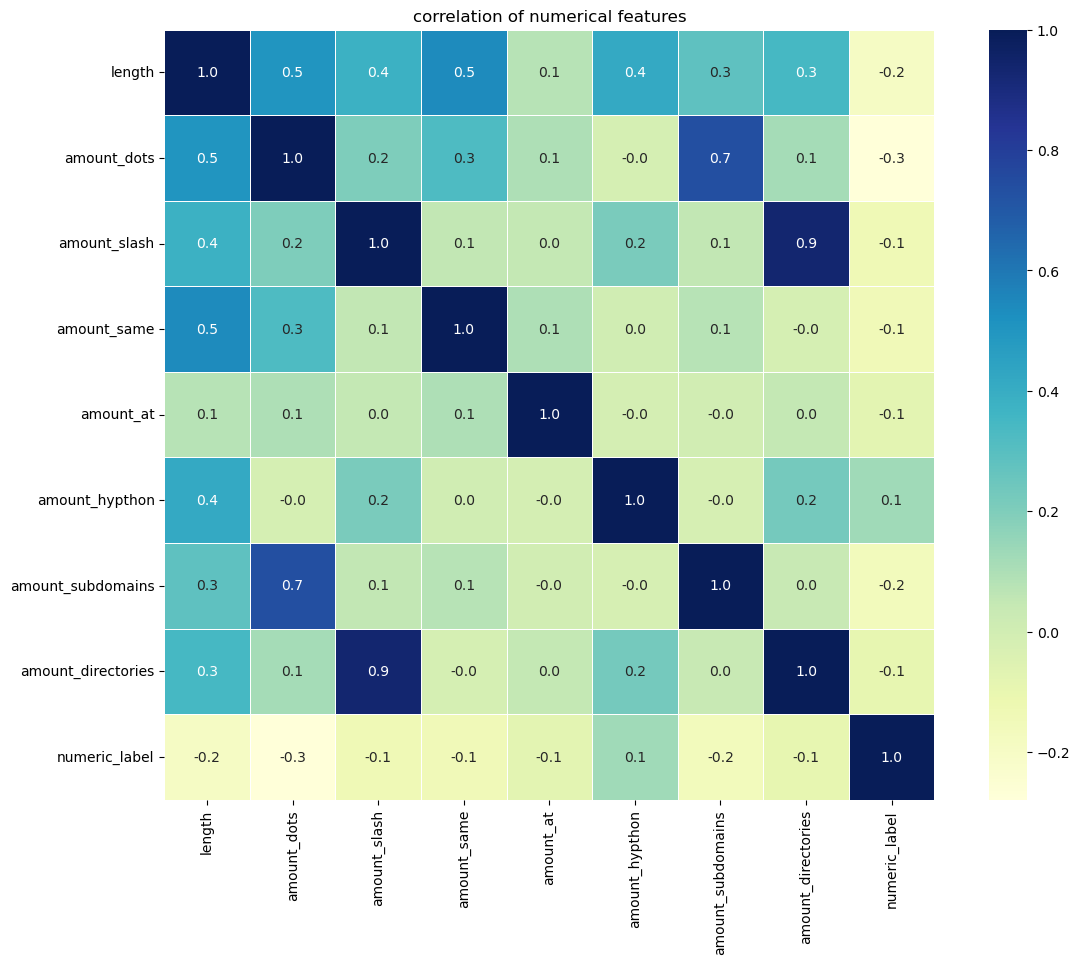

In [53]:
plt.figure(figsize = (14, 10))
sns.heatmap(df.corr(), vmax = 1, linewidths = 0.5, fmt= '.1f',
            square = True, annot = True, cmap = 'YlGnBu', linecolor = "white")
plt.title('correlation of numerical features');

In [55]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
df['text_tokenized'] = df.URL.map(lambda t: tokenizer.tokenize(t))
stemmer = SnowballStemmer("english")
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))

In [56]:
df_phishing = df[df.numeric_label == 1]
df_legitimate = df[df.numeric_label == 0]

In [57]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(8.0,6.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    #more_stopwords = {'com','http','https','org','net','br','edu'}
    #stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

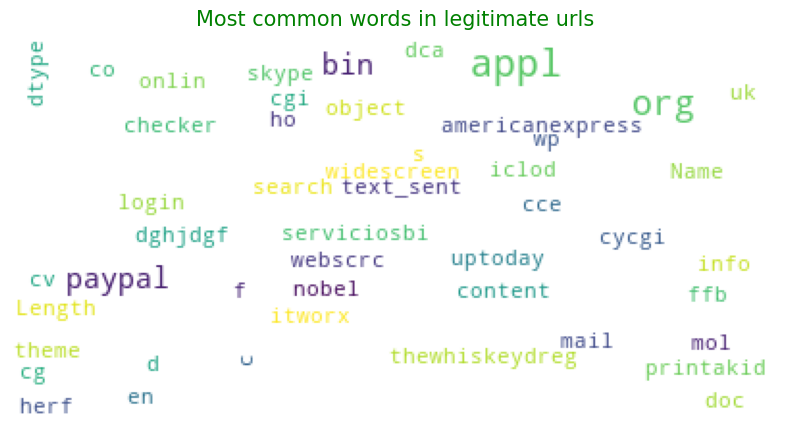

In [58]:
data = df_legitimate.text_sent
data.reset_index(drop=True, inplace=True)
common_text = str(data)
plot_wordcloud(common_text, None, max_words=400, max_font_size=20, 
               title = 'Most common words in legitimate urls', title_size=15)

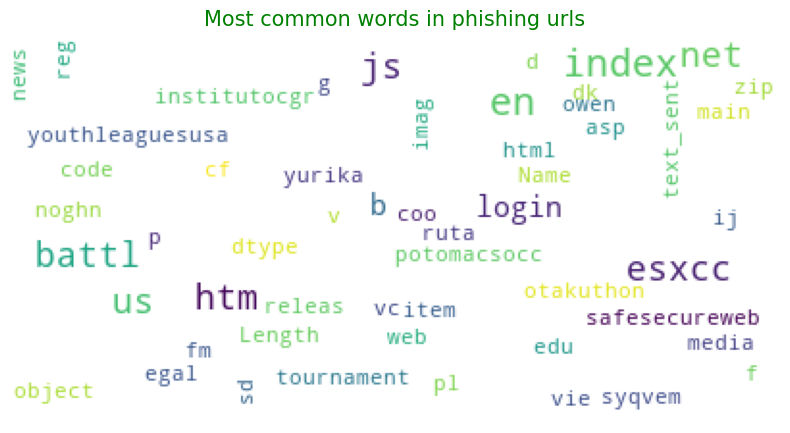

In [59]:
data = df_phishing.text_sent
data.reset_index(drop=True, inplace=True)
common_text = str(data)
plot_wordcloud(common_text, None, max_words=400, max_font_size=20, 
               title = 'Most common words in phishing urls', title_size=15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540890 entries, 0 to 549345
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   URL                 540890 non-null  object
 1   Label               540890 non-null  object
 2   domain              540890 non-null  object
 3   tld                 540890 non-null  object
 4   tld_count           540890 non-null  object
 5   length              540890 non-null  int64 
 6   amount_dots         540890 non-null  int64 
 7   amount_slash        540890 non-null  int64 
 8   amount_same         540890 non-null  int64 
 9   amount_at           540890 non-null  int64 
 10  amount_hypthon      540890 non-null  int64 
 11  amount_subdomains   540890 non-null  int64 
 12  amount_directories  540890 non-null  int64 
 13  numeric_label       540890 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 61.9+ MB


In [ ]:
from sklearn.model_selection import train_test_split

df = df.drop(['URL', 'Label', 'tld_count'], axis=1)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['numeric_label'])

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

cols = df.columns[df.dtypes.eq('object')]

for col in cols:
    df_test[col] = le.fit_transform(df_test[col])
    df_train[col] = le.fit_transform(df_train[col])

In [ ]:
# train-data
y_train = np.asarray(df_train.loc[:, 'numeric_label'])
X_train = np.asarray(df_train.iloc[:, :-1])

# test-data
y_test = np.asarray(df_test.loc[:, 'numeric_label'])
X_test = np.asarray(df_test.iloc[:, :-1])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)

accuracy: 0.6100038824899703
precision: 0.8625219263275394
recall: 0.5507809019513003
f1-score: 0.6722700825752927


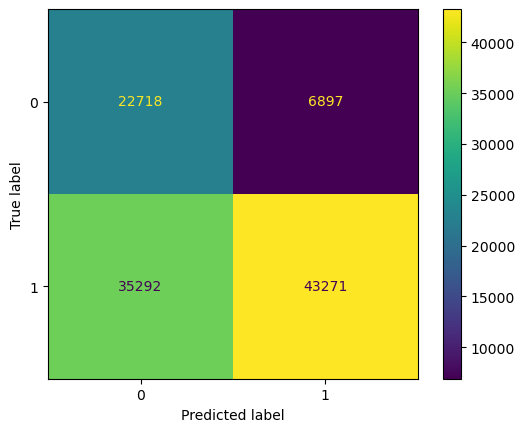

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

rfc_pred = rfc_model.predict(X_test)

print("accuracy: " + str(accuracy_score(y_test, rfc_pred)))
print("precision: " + str(precision_score(y_test, rfc_pred)))
print("recall: " + str(recall_score(y_test, rfc_pred)))
print("f1-score: " + str(f1_score(y_test, rfc_pred)))

cm = confusion_matrix(y_true = y_test, y_pred = rfc_pred)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()